<a href="https://colab.research.google.com/github/fedassembly/tensorflow-cert-prep/blob/main/06_Transfer_Learning_in_TensorFlow_Part_3_Scaling_up_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.

In [1]:
import pathlib
import tensorflow as tf

dataset_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix("")

1625420029/1625420029 [==============================] - 18s 0us/step


In [2]:
class_counts = {"train": {}, "test": {}}
for f in data_dir.glob("**/*.jp*g"):
  split = f.parent.parent.name
  class_name = f.parent.name
  if class_name not in class_counts[split].keys():
    class_counts[split][class_name] = 0
  class_counts[split][class_name] += 1

In [3]:
class_counts

{'train': {'lobster_bisque': 75,
  'donuts': 75,
  'cheese_plate': 75,
  'foie_gras': 75,
  'filet_mignon': 75,
  'hummus': 75,
  'sushi': 75,
  'risotto': 75,
  'baby_back_ribs': 75,
  'caprese_salad': 75,
  'churros': 75,
  'ravioli': 75,
  'caesar_salad': 75,
  'baklava': 75,
  'peking_duck': 75,
  'sashimi': 75,
  'hamburger': 75,
  'creme_brulee': 75,
  'pho': 75,
  'falafel': 75,
  'waffles': 75,
  'frozen_yogurt': 75,
  'gyoza': 75,
  'ramen': 75,
  'grilled_salmon': 75,
  'lobster_roll_sandwich': 75,
  'beet_salad': 75,
  'club_sandwich': 75,
  'spaghetti_carbonara': 75,
  'beef_carpaccio': 75,
  'miso_soup': 75,
  'french_toast': 75,
  'prime_rib': 75,
  'bibimbap': 75,
  'samosa': 75,
  'ceviche': 75,
  'beignets': 75,
  'macarons': 75,
  'eggs_benedict': 75,
  'guacamole': 75,
  'edamame': 75,
  'grilled_cheese_sandwich': 75,
  'french_onion_soup': 75,
  'apple_pie': 75,
  'hot_dog': 75,
  'seaweed_salad': 75,
  'chicken_quesadilla': 75,
  'bruschetta': 75,
  'clam_chowder':

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "train",
    label_mode="categorical",
    class_names=class_counts["train"].keys(),
    image_size=(224, 224),
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "test",
    label_mode="categorical",
    class_names=class_counts["test"].keys(),
    image_size=(224, 224),
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


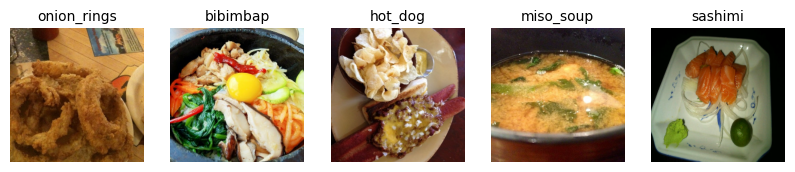

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(10, 7))
samples = list(train_ds.take(1).unbatch().as_numpy_iterator())[:5]
for ax, (img, lab) in zip(axs, samples):
  rescaled_image = img / 255.
  class_label = list(class_counts["train"].keys())[lab.argmax()]
  ax.imshow(rescaled_image)
  ax.axis("off")
  ax.set_title(class_label, fontsize=10)


In [6]:
def create_model():
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False
  feature_extractor = tf.keras.layers.GlobalAvgPool2D(name="feature_extractor")
  # Mixed precision is the use of both 16-bit and 32-bit floating-point types
  # in a model during training to make it run faster and use less memory
  # mixed_float16 policy layers use float16 computations and float32 variables
  # Computations are done in float16 for performance, but variables must be
  # kept in float32 for numeric stability
  # Each layer has a policy and uses the global policy by default
  # A softmax activation at the end of the model should be float32.
  # By separating the dense and softmax layers, we can set dtype mixed_float16
  # policy for the dense layer and dtype float32 for the softmax layer
  dense_layer = tf.keras.layers.Dense(101, name="dense")
  softmax = tf.keras.layers.Activation("softmax", dtype="float32", name="outputs")

  inputs = tf.keras.Input(shape=(224, 224, 3), name="inputs")
  # BatchNormalization contains 2 non-trainable weights that get updated
  # during training. These are the variables tracking the mean and variance of
  # the inputs.
  # When you unfreeze a model that contains BatchNormalization layers in order
  # to do fine-tuning, you should keep the BatchNormalization layers in
  # inference mode by passing training=False when calling the base model.
  x = base_model(inputs, training=False)
  x = feature_extractor(x)
  x = dense_layer(x)
  outputs = softmax(x)
  model = tf.keras.Model(inputs, outputs)
  return model

model_0 = create_model()
model_0.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_0.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 feature_extractor (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 outputs (Activation)        (None, 101)               0         
                                                              

In [7]:
history_0 = model_0.fit(train_ds,
                        epochs=5,
                        validation_data=test_ds,
                        validation_steps=50)

Epoch 1/5
237/237 [==============================] - 39s 100ms/step - loss: 3.0759 - accuracy: 0.3440 - val_loss: 2.1116 - val_accuracy: 0.5288
Epoch 2/5
237/237 [==============================] - 20s 84ms/step - loss: 1.7518 - accuracy: 0.6087 - val_loss: 1.7029 - val_accuracy: 0.5888
Epoch 3/5
237/237 [==============================] - 21s 89ms/step - loss: 1.3458 - accuracy: 0.6917 - val_loss: 1.5621 - val_accuracy: 0.6112
Epoch 4/5
237/237 [==============================] - 20s 85ms/step - loss: 1.1051 - accuracy: 0.7538 - val_loss: 1.4797 - val_accuracy: 0.6200
Epoch 5/5
237/237 [==============================] - 21s 88ms/step - loss: 0.9353 - accuracy: 0.7992 - val_loss: 1.4400 - val_accuracy: 0.6288


In [8]:
model_0.evaluate(test_ds)

790/790 [==============================] - 55s 69ms/step - loss: 1.4254 - accuracy: 0.6267


[1.4254295825958252, 0.6266534924507141]

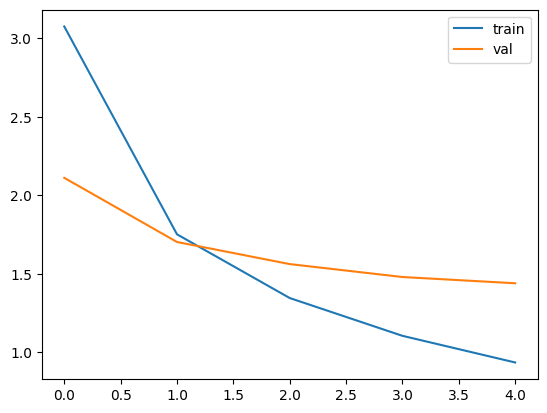

In [9]:
plt.plot(history_0.history["loss"], label="train")
plt.plot(history_0.history["val_loss"], label="val")
plt.legend()
plt.show()

In [10]:
for layer in model_0.layers[1].layers[-20:]:
  layer.trainable = True

# Calling compile() on a model is meant to "freeze" the behavior of that model.
# This implies that the trainable attribute values at the time the model is
# compiled should be preserved throughout the lifetime of that model, until
# compile is called again. Hence, if you change any trainable value, make sure
# to call compile() again on your model for your changes to be taken into account.

model_0.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

for layer in model_0.layers[1].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [11]:
history_1 = model_0.fit(train_ds,
                        epochs=len(history_0.epoch) * 2,
                        initial_epoch=history_0.epoch[-1] + 1,
                        validation_data=test_ds,
                        validation_steps=50)

Epoch 6/10
237/237 [==============================] - 30s 98ms/step - loss: 0.7742 - accuracy: 0.8529 - val_loss: 1.4324 - val_accuracy: 0.6325
Epoch 7/10
237/237 [==============================] - 22s 91ms/step - loss: 0.7501 - accuracy: 0.8636 - val_loss: 1.4129 - val_accuracy: 0.6375
Epoch 8/10
237/237 [==============================] - 21s 87ms/step - loss: 0.7345 - accuracy: 0.8668 - val_loss: 1.4104 - val_accuracy: 0.6363
Epoch 9/10
237/237 [==============================] - 21s 85ms/step - loss: 0.7198 - accuracy: 0.8697 - val_loss: 1.4086 - val_accuracy: 0.6363
Epoch 10/10
237/237 [==============================] - 21s 88ms/step - loss: 0.7060 - accuracy: 0.8738 - val_loss: 1.4127 - val_accuracy: 0.6344


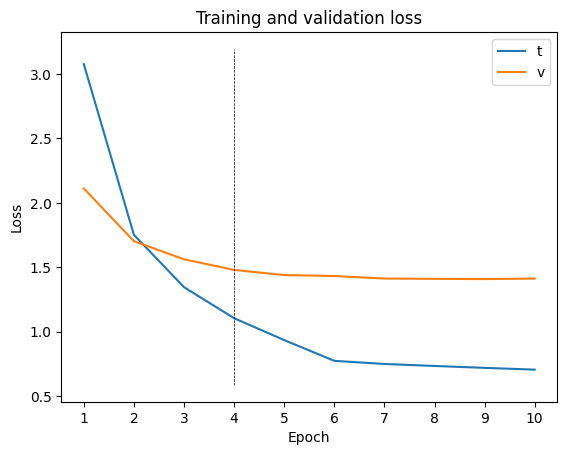

In [12]:
plt.plot(range(1, 11), history_0.history["loss"] + history_1.history["loss"], label="t")
plt.plot(range(1, 11), history_0.history["val_loss"] + history_1.history["val_loss"], label="v")
plt.vlines(x=history_0.epoch[-1],
           ymin=plt.ylim()[0], ymax=plt.ylim()[1],
           color="k", linestyle="--", linewidth=0.5)
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, 11))
plt.legend()
plt.show()

In [13]:
model_0.evaluate(test_ds)

790/790 [==============================] - 54s 68ms/step - loss: 1.3811 - accuracy: 0.6375


[1.3811198472976685, 0.6375049352645874]

In [14]:
!rm -rf /content/my_food_images/
!mkdir -p /content/my_food_images/
!wget -q -O /content/my_food_images/vegan_ramen.jpg 'https://bittenoxford.co.uk/wp-content/uploads/2022/11/7a40f55e-2177-4c60-b1de-1370f6952812.jpg'
!wget -q -O /content/my_food_images/vegan_sausage_rolls.jpg 'https://www.chooseveganism.org/wp-content/uploads/Greggs-Vegan-Sausage-Roll-4-1.jpg'
!wget -q -O /content/my_food_images/vegan_kebab.png 'https://whatthepitta.com/wp-content/uploads/2021/10/what-the-pitta-main-side-drink.png'

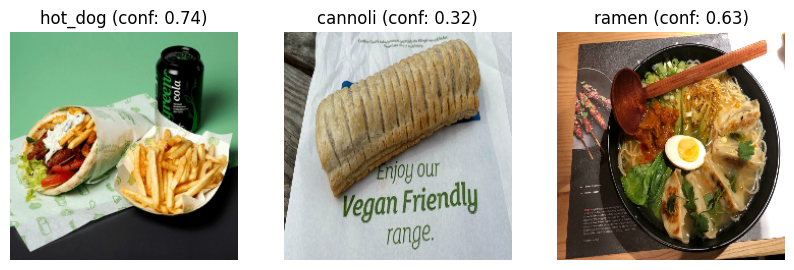

In [16]:
images_dir = pathlib.Path("/content/my_food_images")
images = list(images_dir.glob("*"))
fig, axs = plt.subplots(1, 3, figsize=(10, 7))
for ax, image_path in zip(axs, images):
  raw = tf.io.read_file(str(image_path))
  img = tf.io.decode_image(raw)
  img = tf.image.resize(img, [224, 224])
  pred_probs = model_0.predict(tf.expand_dims(img, axis=0), verbose=0)
  pred_argmax = pred_probs.argmax()
  pred_conf = pred_probs[:,pred_argmax][0]
  pred_class = list(class_counts["train"].keys())[pred_argmax]
  ax.imshow(img/255.)
  ax.set_title(f"{pred_class} (conf: {pred_conf:.2f})")
  ax.axis("off")

2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [17]:
ten_epochs_model = create_model()
ten_epochs_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_2 = ten_epochs_model.fit(train_ds, epochs=10, validation_data=test_ds, validation_steps=50)

Epoch 1/10
237/237 [==============================] - 33s 106ms/step - loss: 3.0555 - accuracy: 0.3525 - val_loss: 2.1095 - val_accuracy: 0.5219
Epoch 2/10
237/237 [==============================] - 23s 96ms/step - loss: 1.7461 - accuracy: 0.6099 - val_loss: 1.6919 - val_accuracy: 0.5919
Epoch 3/10
237/237 [==============================] - 22s 93ms/step - loss: 1.3422 - accuracy: 0.6956 - val_loss: 1.5712 - val_accuracy: 0.6056
Epoch 4/10
237/237 [==============================] - 21s 87ms/step - loss: 1.1053 - accuracy: 0.7543 - val_loss: 1.4834 - val_accuracy: 0.6194
Epoch 5/10
237/237 [==============================] - 23s 94ms/step - loss: 0.9322 - accuracy: 0.8018 - val_loss: 1.4578 - val_accuracy: 0.6169
Epoch 6/10
237/237 [==============================] - 22s 90ms/step - loss: 0.8002 - accuracy: 0.8391 - val_loss: 1.4267 - val_accuracy: 0.6300
Epoch 7/10
237/237 [==============================] - 22s 93ms/step - loss: 0.6914 - accuracy: 0.8657 - val_loss: 1.4028 - val_accuracy

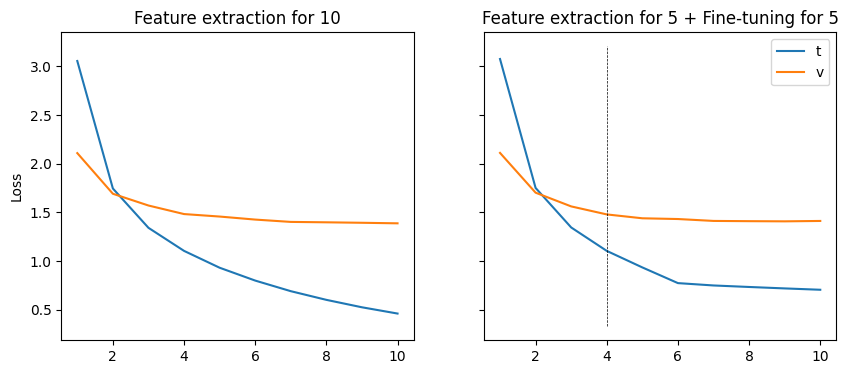

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
epochs = range(1, 11)
ax1.plot(epochs, history_2.history["loss"], label="t")
ax1.plot(epochs, history_2.history["val_loss"], label="v")
ax2.plot(epochs, history_0.history["loss"] + history_1.history["loss"], label="t")
ax2.plot(epochs, history_0.history["val_loss"] + history_1.history["val_loss"], label="v")
ax2.vlines(x=history_0.epoch[-1],
           ymin=plt.ylim()[0], ymax=plt.ylim()[1],
           color="k", linestyle="--", linewidth=0.5)
ax1.set_ylabel("Loss")
ax1.set_title("Feature extraction for 10")
ax2.set_title("Feature extraction for 5 + Fine-tuning for 5")
ax2.legend()
plt.show()

In [19]:
ten_epochs_model.evaluate(test_ds)

790/790 [==============================] - 55s 69ms/step - loss: 1.3663 - accuracy: 0.6361


[1.3663021326065063, 0.6360791921615601]

Recreate the first model (the feature extraction model) with [mixed_precision](https://www.tensorflow.org/guide/mixed_precision) turned on.
- Does it make the model train faster?
- Does it effect the accuracy or performance of our model?
- What's the advantages of using mixed_precision training?

In [20]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")
model_fast = create_model()
for layer in model_fast.layers:
  print(layer.name,
        "Policy:", layer.dtype_policy.name,
        "Input:", layer.input.dtype.name,
        "Output:", layer.output.dtype.name)

inputs Policy: float32 Input: float32 Output: float32
efficientnetb0 Policy: mixed_float16 Input: float32 Output: float16
feature_extractor Policy: mixed_float16 Input: float16 Output: float16
dense Policy: mixed_float16 Input: float16 Output: float16
outputs Policy: float32 Input: float16 Output: float32


In [21]:
model_fast.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_3 = model_fast.fit(train_ds, epochs=10, validation_data=test_ds, validation_steps=50)

Epoch 1/10
237/237 [==============================] - 32s 96ms/step - loss: 3.0565 - accuracy: 0.3467 - val_loss: 2.0798 - val_accuracy: 0.5506
Epoch 2/10
237/237 [==============================] - 20s 81ms/step - loss: 1.7430 - accuracy: 0.6121 - val_loss: 1.7019 - val_accuracy: 0.5844
Epoch 3/10
237/237 [==============================] - 19s 77ms/step - loss: 1.3411 - accuracy: 0.6941 - val_loss: 1.5604 - val_accuracy: 0.6056
Epoch 4/10
237/237 [==============================] - 22s 90ms/step - loss: 1.1020 - accuracy: 0.7527 - val_loss: 1.4986 - val_accuracy: 0.6150
Epoch 5/10
237/237 [==============================] - 21s 86ms/step - loss: 0.9325 - accuracy: 0.7993 - val_loss: 1.4579 - val_accuracy: 0.6212
Epoch 6/10
237/237 [==============================] - 21s 87ms/step - loss: 0.7978 - accuracy: 0.8374 - val_loss: 1.4504 - val_accuracy: 0.6256
Epoch 7/10
237/237 [==============================] - 21s 88ms/step - loss: 0.6903 - accuracy: 0.8661 - val_loss: 1.4153 - val_accuracy:

It doesn't seem to affect neither speed nor performance. Maybe 1 second per epoch. You would probably need a very large dataset to see a meaningful difference.

The advantages of using `mixed_precision` are probably more in terms of memory than speed.